In [1]:
%matplotlib widget

from pathlib import Path
import json

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns

import biopsykit.carwatch_logs.log_actions as la
import biopsykit.carwatch_logs.log_extras as le
from biopsykit import carwatch_logs as cl
from biopsykit.io import carwatch_logs

from carwatch_analysis.saliva_helper import import_cortisol_raw, import_cortisol_features, analysis_saliva_raw, analysis_saliva_features

import biopsykit as bp

import datetime

from IPython.display import display

## Load Self-Report Data

In [2]:
export_path = Path("../..").joinpath("exports")

In [3]:
data_raw = pd.read_csv(export_path.joinpath("cortisol_samples_cleaned.csv"))

In [4]:
data_raw.head()

,condition,subject,chronotype,MEQ,night,within_ideal_bed_time,wakeup_source,date,weekend,wakeup_hour,sample,cortisol,time
0,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S0,10.28,0.0
1,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S1,12.37,17.0
2,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S2,10.41,32.0
3,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S3,10.22,47.0
4,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S4,8.21,62.0


## Load App Logs

In [5]:
logs_path = Path("../../../carwatch-data/App_Logs/cleaned_manual")
logs = carwatch_logs.load_logs_all_subjects(logs_path, has_subject_folders=False, return_df=False)

  0%|          | 0/65 [00:00<?, ?it/s]

## Load Cleaned App Wakeup Onsets

In [7]:
app_wakeup_path = Path("../../../carwatch-data/App_Logs/app_data_wakeup.xlsx")

app_data = pd.read_excel(app_wakeup_path)
app_data.index = app_data['Code']
#app_data.drop(['Code'], axis=1, inplace=True)
app_data.head()

,Code,0,1
Code,,,
CE10B,CE10B,04:48:53,05:40:54
EA09H,EA09H,09:17:47,08:11:54
EM16N,EM16N,08:51:12,NaN
KA17A,KA17A,06:39:00,05:41:00
KA19E,KA19E,NaN,NaN


In [8]:
app_data_long = app_data.melt(['Code'], [0,1], 'night', 'time')
app_data_long.set_index(['Code', 'night'], inplace=True)
app_data_long.dropna(inplace=True)
app_data_long = pd.to_timedelta(app_data_long['time'])
app_data_long.head()

Code   night
CE10B  0       0 days 04:48:53
EA09H  0       0 days 09:17:47
EM16N  0       0 days 08:51:12
KA17A  0       0 days 06:39:00
LB21E  0       0 days 08:57:41
Name: time, dtype: timedelta64[ns]

## Load Self-Report Wakeup Onsets

In [9]:
self_report_wake_onset_path = export_path.joinpath("imu_questionnaire_merged.csv")

In [10]:
sr_wake_onset = pd.read_csv(self_report_wake_onset_path)

In [11]:
# Rename and set index

sr_wake_onset.rename({"subject": "Code"}, inplace=True, axis=1)
sr_wake_onset.set_index(["Code", "night"], inplace=True)

In [12]:
sr_wake_onset.head()

MEQ  chronotype_coarse  sleep_onset_latency  getup_latency  \
Code  night                                                                
AB19E 0      45.0                1.0                  1.0            2.0   
      1      45.0                1.0                  NaN            NaN   
AB31R 0      56.0                1.0                 27.0            4.0   
      1      56.0                1.0                 13.0            1.0   
AC12E 0      46.0                1.0                 34.0           40.0   

             wake_after_sleep_onset sleep_onset_time  \
Code  night                                            
AB19E 0                        18.0  0 days 00:15:22   
      1                         NaN              NaN   
AB31R 0                         7.0  0 days 00:46:56   
      1                        10.0  0 days 00:41:21   
AC12E 0                        37.0  0 days 23:51:16   

                              bed_time  wake_onset_time  within_ideal_bed_time  
Code  night                                                                     
AB19E 0      0 days 00:14:54.052733952  0 days 05:45:00                      0  
      1                            NaN              NaN                      0  
AB31R 0      0 days 00:20:05.966797056  0 days 05:40:00                      0  
      1      0 days 00:28:30.966797056  0 days 05:50:00                      0  
AC12E 0      0 days 23:17:25.966797056  0 days 07:00:00                      0

In [13]:
wake_onset_time = sr_wake_onset["wake_onset_time"]

wake_onset_time = pd.to_timedelta(wake_onset_time)
wake_onset_time.dropna(inplace=True)

wake_onset_time = wake_onset_time.apply(lambda x: x.seconds / 60 % 10)

freq_app = app_data_long.apply(lambda x: x.seconds / 60 % 10)

Text(0.5, 1.0, 'app')

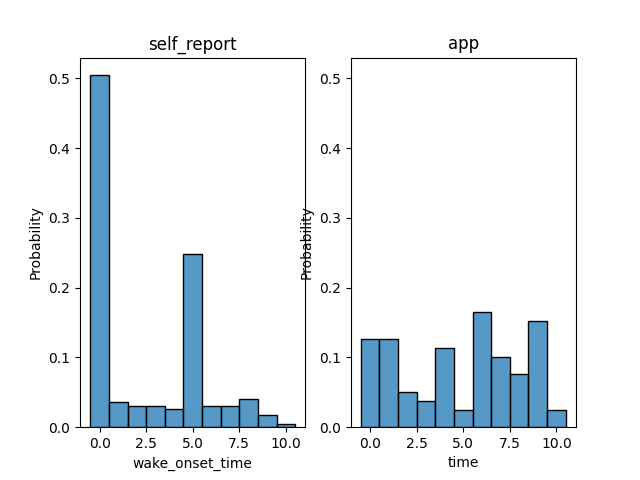

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.sharey(ax2)
sns.histplot(wake_onset_time,stat="probability", bins=10, discrete=True, ax=ax1).set_title('self_report')
sns.histplot(freq_app,stat="probability", bins=10, discrete=True, ax=ax2).set_title('app')

## Extract Saliva Sample Times From App Logs

In [18]:
#wake_onset = "app"
wake_onset = "self_report"

#sampling_times = "app"
sampling_times = "self_report"

In [27]:
def get_timestamp(df, saliva_id):
    return datetime.datetime.strptime(df.loc[df['saliva_id']==saliva_id].iloc[0].name.strftime("%H:%M:%S"), "%H:%M:%S").time()

def get_datetime(timestring):
    return datetime.datetime.strptime(timestring, "%H:%M:%S").time()

def get_from_json(row):
    json_extra = json.loads(row.extras)
    return json_extra.get('saliva_id')

for subject, subject_log in logs.items():
    log_subject = carwatch_logs.LogData(subject_log)
    
    finished_day = log_subject.finished_days

    df = cl.log_data.get_logs_for_action(log_subject, la.barcode_scanned)

    for day in range(2):
        try:
            df_day = df[df.index.date == finished_day[day]]
            df_day['saliva_id'] = df_day.apply(lambda row: get_from_json(row), axis=1)
            
            if pd.isna(app_data.loc[subject, day]):
                continue
            
            T0 = get_datetime(app_data.loc[subject, day])
            T0_delta = datetime.timedelta(hours=T0.hour, minutes=T0.minute, seconds=T0.second)
            
            T0_delta_sr = pd.to_timedelta(sr_wake_onset.query("Code == @subject & night == @day")["wake_onset_time"].item())
            #print(T0_delta)
            
            for saliva_id in range(5):
                T = get_timestamp(df_day, saliva_id)
                T_delta = datetime.timedelta(hours=T.hour, minutes=T.minute, seconds=T.second)
                #data_raw.loc[(data_raw['subject']==subject) & (data_raw['night']==day) & (data_raw['sample']=='S'+str(saliva_id)), 'onset_sr_samples_app'] = (T_delta-T0_delta_sr).total_seconds() / 60
                #data_raw.loc[(data_raw['subject']==subject) & (data_raw['night']==day) & (data_raw['sample']=='S'+str(saliva_id)), 'onset_app_samples_sr'] = (T_delta-T0_delta).total_seconds() / 60
                data_raw.loc[(data_raw['subject']==subject) & (data_raw['night']==day) & (data_raw['sample']=='S'+str(saliva_id)), 'time_app'] = (T_delta-T0_delta).total_seconds() / 60
                data_raw.loc[(data_raw['subject']==subject) & (data_raw['night']==day) & (data_raw['sample']=='S'+str(saliva_id)), 'naive'] = saliva_id*15.0
                

                
        except IndexError:
            pass

data = data_raw.rename(columns={'time':'self_report','time_app':'app'})

C:\Users\Luca\AppData\Local\Temp/ipykernel_13056/2942498493.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_day = df[df.index.date == finished_day[day]]
C:\Users\Luca\AppData\Local\Temp/ipykernel_13056/2942498493.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_day = df[df.index.date == finished_day[day]]
C:\Users\Luca\AppData\Local\Temp/ipykernel_13056/2942498493.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(dat

In [28]:
data.head()

,condition,subject,chronotype,MEQ,night,within_ideal_bed_time,wakeup_source,date,weekend,wakeup_hour,sample,cortisol,self_report,app,naive
0,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S0,10.28,0.0,NaN,NaN
1,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S1,12.37,17.0,NaN,NaN
2,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S2,10.41,32.0,NaN,NaN
3,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S3,10.22,47.0,NaN,NaN
4,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S4,8.21,62.0,NaN,NaN


In [40]:
# Optional: drop all subjects with self report only
data_clean = data.dropna()
self_report_only = data[~data.index.isin(data_clean.index)]

self_report_only.head()

,condition,subject,chronotype,MEQ,night,within_ideal_bed_time,wakeup_source,date,weekend,wakeup_hour,sample,cortisol,self_report,app,naive
0,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S0,10.28,0.0,NaN,NaN
1,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S1,12.37,17.0,NaN,NaN
2,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S2,10.41,32.0,NaN,NaN
3,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S3,10.22,47.0,NaN,NaN
4,Spontaneous,AB31R,Intermediate,56.0,0,False,Spontaneous,2020-01-08,Weekday,5,S4,8.21,62.0,NaN,NaN


In [33]:
id_vars = ['subject', 'condition', 'chronotype', 'MEQ', 'night', 'wakeup_source', 'weekend', 'date', 'wakeup_hour', 'sample', 'cortisol']
value_vars = ['self_report','app','naive']
cort_long = data.melt(id_vars=id_vars, value_vars=value_vars, var_name='log_mode', value_name='time')

cort_long.dropna(inplace=True)

# Something went wrong there, drop manually
cort_long = cort_long.loc[~((cort_long["subject"]=="MD26R")&( cort_long["log_mode"]=="app")),:]
       
cort_long.head()

,subject,condition,chronotype,MEQ,night,wakeup_source,weekend,date,wakeup_hour,sample,cortisol,log_mode,time
0,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S0,10.28,self_report,0.0
1,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S1,12.37,self_report,17.0
2,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S2,10.41,self_report,32.0
3,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S3,10.22,self_report,47.0
4,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S4,8.21,self_report,62.0


In [47]:
cort_long_self_report_only = self_report_only.melt(id_vars=id_vars, value_vars=value_vars, var_name='log_mode', value_name='time')

cort_long_self_report_only.dropna(inplace=True)

cort_long_self_report_only.head()

,subject,condition,chronotype,MEQ,night,wakeup_source,weekend,date,wakeup_hour,sample,cortisol,log_mode,time
0,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S0,10.28,self_report,0.0
1,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S1,12.37,self_report,17.0
2,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S2,10.41,self_report,32.0
3,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S3,10.22,self_report,47.0
4,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,S4,8.21,self_report,62.0


In [46]:
# export
cort_long_self_report_only.to_csv(export_path.joinpath('cortisol_samples_self_report_only.csv'),index=False)

In [43]:
# export
cort_long.to_csv(export_path.joinpath('cortisol_samples_app_cleaned.csv'), index=False)

In [58]:
idx = ['subject', 'condition', 'chronotype', 'MEQ', 'night', 'wakeup_source', 'weekend', 'date', 'wakeup_hour', 'log_mode', 'sample']
cort_long.set_index(idx, inplace = True)

In [59]:
cort_long.head()

# 56 complete samples

cortisol  \
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode    sample             
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           self_report S0          5.88   
                                                                                                     S1         12.54   
                                                                                                     S2         12.91   
                                                                                                     S3         12.30   
                                                                                                     S4         10.38   

                                                                                                             time  
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode    sample        
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           self_report S0       0.0  
                                                                                                     S1      15.0  
                                                                                                     S2      30.0  
                                                                                                     S3      45.0  
                                                                                                     S4      60.0

## Compute Cortisol Features For App Times

In [31]:
# cort_long_app = cort_long.query("log_mode=='app'")

In [67]:
cort_auc = bp.saliva.auc(cort_long, remove_s0=False)
cort_auc.head()

saliva_feature                                                                                        cortisol_auc_g  \
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode                      
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           app              697.398333   
                                                                                         naive            688.200000   
                                                                                         self_report      688.200000   
                                      1     Spontaneous   Weekend 2019-12-08 8           app              945.144250   
                                                                                         naive            936.900000   

saliva_feature                                                                                        cortisol_auc_i  
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode                     
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           app              339.698333  
                                                                                         naive            335.400000  
                                                                                         self_report      335.400000  
                                      1     Spontaneous   Weekend 2019-12-08 8           app              630.803250  
                                                                                         naive            625.500000

In [68]:
#cort_inc = bp.saliva.max_increase(cort_long, remove_s0=False)
#cort_inc.head()

In [69]:
cort_slope = bp.saliva.slope(cort_long, sample_idx=[0, 3])
cort_slope = cort_slope.join(bp.saliva.slope(cort_long, sample_idx=[0, 4]))
#cort_slope = cort_slope.join(bp.saliva.slope(cort_long, sample_idx=[2, 4], biomarker_type='cortisol'))
cort_slope.head()

saliva_feature                                                                                        cortisol_slopeS0S3  \
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode                          
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           app                    0.140430   
                                                                                         naive                  0.142667   
                                                                                         self_report            0.142667   
                                      1     Spontaneous   Weekend 2019-12-08 8           app                    0.321892   
                                                                                         naive                  0.325111   

saliva_feature                                                                                        cortisol_slopeS0S4  
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode                         
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           app                    0.073973  
                                                                                         naive                  0.075000  
                                                                                         self_report            0.075000  
                                      1     Spontaneous   Weekend 2019-12-08 8           app                    0.151238  
                                                                                         naive                  0.152667

In [70]:
#cort_max = pd.DataFrame(cort_long['cortisol'].unstack('sample').max(axis=1), columns=['cortisol_cmax'])
#cort_max.head()

In [71]:
#cort_cini = cort_long.xs('S0', level='sample')[['cortisol']]
#cort_cini.columns = ["cortisol_cini"]
#cort_cini.head()

In [72]:
cort_feat = pd.concat([cort_auc, cort_inc, cort_slope, cort_cini, cort_max], axis=1)
cort_feat = pd.DataFrame(cort_feat.stack(), columns=['cortisol'])
cort_feat.index = cort_feat.index.set_names(cort_feat.index.names[:-1] + ['saliva_feature'])
cort_feat.head()

cortisol
subject condition   chronotype   MEQ  night wakeup_source weekend date       wakeup_hour log_mode saliva_feature                
BC05R   Spontaneous Intermediate 47.0 0     Spontaneous   Weekend 2019-12-07 7           app      cortisol_auc_g      697.398333
                                                                                                  cortisol_auc_i      339.698333
                                                                                                  cortisol_max_inc      7.030000
                                                                                                  cortisol_slopeS0S3    0.140430
                                                                                                  cortisol_slopeS0S4    0.073973

In [74]:
# export
cort_feat.to_csv(export_path.joinpath('cortisol_features_app_cleaned.csv'))